In [120]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from scipy.spatial.distance import euclidean

from imputers import KNNImputerMode, KNNImputerMedian

In [121]:
data = pd.read_csv('./Financial Well-Being Survey Data/NFWBS_PUF_2016_data.csv')

print(f'The dataset contains {data.shape[0]} rows and {data.shape[1]} features.')

The dataset contains 6394 rows and 217 features.


In [122]:
data.duplicated().sum()

0

# Data cleaning

In [123]:
data.set_index('PUF_ID', inplace=True)

## Dropping irrelevant features

We can remove features that were used to feature engineering

Engineered features: 
- FWBScore: created from FWB questions
- FSscore: created from FS questions
- LMscore: created from FINKKNOWL questions + FKcorrect
- KHscore: created from KHKNOWL questions + KHcorrect
- ON1correct: OBJNUMERACY1
- ON2correct: OBJNUMERACY2

In [124]:
FWB_cols = list(filter(lambda x: 'FWB' in x, data.columns.values))
FWB_drop = FWB_cols[1:]
data.drop(FWB_drop, axis = 1, inplace = True)

list(filter(lambda x: 'FWB' in x, data.columns.values))

['FWBscore']

In [125]:
FS_cols = list(filter(lambda x: 'FS' in x, data.columns.values))
FS_cols = FS_cols[1:]
data.drop(FS_cols, axis = 1, inplace = True)

list(filter(lambda x: 'FS' in x, data.columns.values))

['FSscore']

In [126]:
LM_cols = list(filter(lambda x: 'FINKNOWL' in x, data.columns.values))

data.drop(LM_cols, axis = 1, inplace = True)

list(filter(lambda x: 'FINKNOWL' in x, data.columns.values))

[]

In [127]:
FKcorrect_cols = ['FK1correct', 'FK2correct', 'FK3correct']

data.drop(FKcorrect_cols, axis = 1, inplace = True)

In [128]:
KH_cols = list(filter(lambda x: 'KHKNOWL' in x, data.columns.values))

data.drop(KH_cols, axis = 1, inplace = True)

list(filter(lambda x: 'KHKNOWL' in x, data.columns.values))

[]

In [129]:
KHcorrect_cols = ['KH1correct', 'KH2correct', 'KH3correct', 'KH4correct', 'KH5correct', 'KH6correct', 'KH7correct', 'KH8correct', 'KH9correct']

data.drop(KHcorrect_cols, axis = 1, inplace = True)

In [130]:
OBJNUMcols = list(filter(lambda x: 'OBJNUMERACY' in x, data.columns.values))

data.drop(OBJNUMcols, axis = 1, inplace = True)

list(filter(lambda x: 'OBJNUMERACY' in x, data.columns.values))

[]

In [131]:
data.head()

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,2,3,5,5,6,55,44,5,4,3,...,1,4,8,0,0,0,0,1,0,0.367292
7740,1,3,6,6,6,51,43,5,4,3,...,1,2,3,0,0,0,0,2,0,1.327561
13699,1,3,4,3,4,49,42,5,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
7267,1,3,6,6,6,49,42,-1,-1,-1,...,1,3,7,0,0,0,0,1,0,1.410871
7375,1,3,4,4,4,49,42,4,3,3,...,1,2,4,0,0,1,0,4,1,4.260668


## Missing values

__-5: County not known__


Use PPREG9, PPINCIMP and PPEDUC to impute PCTLT200FPL
PPEDUC: ordinal
<br>
PPINCIMP: ordinal
<br>
PPREG9: categorical

distance to find nearest neighbors: euclidean for PPINC, PPEDUC  + one hot for PPREG9

In [132]:
# replace by missing values
data = data.replace(-5, np.nan)

In [133]:
nrows = data[data['PCTLT200FPL'].isna()].shape[0]
print(f'nr of rows with missing value: {nrows}')

nr of rows with missing value: 395


In [134]:
def distance(X, Y, missing_values = np.nan):
    
    X[np.isnan(X)] = 0
    Y[np.isnan(Y)] = 0

    eucl_dist = euclidean(X[[0, 1]], Y[[0, 1]])

    return eucl_dist + (X[2] != Y[2])

In [135]:
imputer = KNNImputerMode(n_neighbors = 5, metric = distance)

cols = ['PPEDUC', 'PPINCIMP', 'PPREG9', 'PCTLT200FPL']

new_data = imputer.fit_transform(data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = data.index)

In [136]:
new_data['PCTLT200FPL'].value_counts()

0.0    4842
1.0    1552
Name: PCTLT200FPL, dtype: int64

In [137]:
data.loc[data['PCTLT200FPL'].isna(), 'PCTLT200FPL'] = new_data.loc[data['PCTLT200FPL'].isna(), 'PCTLT200FPL'].copy()

__-4: Response not written to the database due to error__: SWB only (because FWB dropped) ->DROP

In [138]:
data[(data == -4).any(axis = 1)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
12173,1,3,-4,-4,-4,-4,48,7,4,3,...,1,3,5,0,0,0,0,1,0.0,1.253964


In [139]:
data.drop(12173, axis = 0, inplace = True)

__-3: Invalid response/ Incoherent data__

- Drop the only row with KIDS_2 = -3
- Replace -3 with -2 for SOCSEC2 because -3 are caused by invalid age, therefore -2 is the adequate label.
- Replace -3 with the mode for SOCSEC3

KIDS_2 drop

In [140]:
data[data['KIDS_2'] == -3]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
13237,1,2,3,7,7,52,50,5,4,4,...,1,2,3,0,0,1,1,3,0.0,1.690435


In [141]:
data.drop(13237, axis = 0, inplace = True)

SOCSEC2

In [142]:
data['SOCSEC2'] = data['SOCSEC2'].replace(-3, -2).copy()

SOCSEC3

In [143]:
data = data.replace(-3, np.nan)

In [144]:
data.loc[data['SOCSEC3'].isna(), 'SOCSEC3'] = data['SOCSEC3'].mode()[0]

In [145]:
data['SOCSEC3'].value_counts()

-2.0     2321
 65.0    1221
 70.0     723
 67.0     451
 61.0     406
 62.0     372
 71.0     364
 68.0     160
-1.0      140
 66.0     118
 63.0      51
 69.0      41
 64.0      24
Name: SOCSEC3, dtype: int64

__8: I can't recall__

HSLOC: Where respondent attended high school
- 1: US and territories
- 2: Outside the US
- 8: Can't recall

COLLECT: Contacted by debt collector in past 12 months TODO!

What do to?
- impute with mode

In [146]:
data.loc[data['HSLOC'] == 8, 'HSLOC'] = data['HSLOC'].mode()[0]

In [147]:
data['HSLOC'].value_counts()

 1    5406
-1     644
 2     342
Name: HSLOC, dtype: int64

__-1: Not answered/ Left blank__
<br>
__98: Don't know__
<br>
__99: Prefer not to say__

First, let's replace the missing values with NaN

In [148]:
data = data.replace(-1, np.nan)
data = data.replace(98, np.nan)
data = data.replace(99, np.nan)

In [149]:
data[data.isna().sum(axis = 1) >= 5]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
7267,1,3,6.0,6.0,6.0,49.0,42.0,NaN,NaN,NaN,...,1,3,7,0,0,0,0,1,0.0,1.410871
8303,1,3,7.0,7.0,7.0,43.0,58.0,4.0,3.0,3.0,...,1,3,7,0,0,0,1,3,0.0,2.497838
9182,1,3,6.0,NaN,NaN,50.0,43.0,4.0,4.0,3.0,...,1,4,9,0,0,0,0,2,0.0,0.647301
11082,1,3,6.0,6.0,5.0,62.0,55.0,4.0,5.0,4.0,...,1,3,5,0,0,0,0,3,0.0,0.455829
8309,2,3,3.0,4.0,2.0,49.0,37.0,NaN,4.0,3.0,...,1,3,5,0,0,0,0,1,0.0,0.597089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11078,3,1,3.0,4.0,5.0,26.0,44.0,4.0,3.0,3.0,...,1,2,3,0,1,0,0,1,0.0,1.379959
12353,1,3,5.0,7.0,3.0,62.0,26.0,4.0,3.0,3.0,...,1,3,5,0,0,0,0,2,0.0,1.745759
12297,3,3,4.0,5.0,7.0,55.0,45.0,5.0,4.0,3.0,...,1,2,4,0,0,0,1,2,0.0,0.883213


Now let's drop the rows with more than 5 missing values

In [150]:
data.drop(data[data.isna().sum(axis = 1) >= 5].index, axis = 0, inplace = True)

In [151]:
data.shape

(6025, 171)

Now, let's see which columns have missing values

In [152]:
data.isna().sum(axis = 0).index

Index(['sample', 'fpl', 'SWB_1', 'SWB_2', 'SWB_3', 'FWBscore', 'FSscore',
       'SUBKNOWL1', 'ACT1_1', 'ACT1_2',
       ...
       'PPMSACAT', 'PPREG4', 'PPREG9', 'PPT01', 'PPT25', 'PPT612', 'PPT1317',
       'PPT18OV', 'PCTLT200FPL', 'finalwt'],
      dtype='object', length=171)

And how many missing values per column

In [153]:
# how many missing values per column that has missing values
data.isna().sum(axis = 0)[data.isna().sum(axis = 0) > 0]

SWB_1              12
SWB_2              37
SWB_3              38
SUBKNOWL1          34
ACT1_1             14
                   ..
KIDS_4              7
EMPLOY             44
RETIRE              2
MILITARY           15
Military_Status    31
Length: 79, dtype: int64

Get all columns with less than 100 missing values

In [154]:
# get all columns with less than 100 missing values

data.isna().sum(axis = 0)[(data.isna().sum(axis = 0) > 0) & (data.isna().sum(axis = 0) < 100)].index

Index(['SWB_1', 'SWB_2', 'SWB_3', 'SUBKNOWL1', 'ACT1_1', 'ACT1_2', 'FINGOALS',
       'SAVEHABIT', 'FRUGALITY', 'AUTOMATED_1', 'AUTOMATED_2', 'ASK1_1',
       'ASK1_2', 'SUBNUMERACY2', 'SUBNUMERACY1', 'CHANGEABLE', 'GOALCONF',
       'ENDSMEET', 'HOUSING', 'LIVINGARRANGEMENT', 'CONSPROTECT1',
       'CONSPROTECT2', 'CONSPROTECT3', 'EARNERS', 'VOLATILITY', 'SNAP',
       'MATHARDSHIP_6', 'COLLECT', 'REJECTED_1', 'REJECTED_2', 'ABSORBSHOCK',
       'BENEFITS_3', 'BENEFITS_4', 'BENEFITS_5', 'FRAUD2', 'COVERCOSTS',
       'MANAGE2', 'PAIDHELP', 'PAREDUC', 'FINSOC2_3', 'FINSOC2_5', 'FINSOC2_6',
       'MATERIALISM_1', 'MATERIALISM_2', 'MATERIALISM_3', 'HEALTH',
       'SCFHORIZON', 'DISCOUNT', 'MEMLOSS', 'DISTRESS', 'SELFCONTROL_1',
       'SELFCONTROL_2', 'SELFCONTROL_3', 'OUTLOOK_1', 'OUTLOOK_2', 'PEM',
       'HOUSESAT', 'SOCSEC1', 'SOCSEC2', 'SOCSEC3', 'HHEDUC', 'KIDS_1',
       'KIDS_2', 'KIDS_3', 'KIDS_4', 'EMPLOY', 'RETIRE', 'MILITARY',
       'Military_Status'],
      dtype='object'

In [155]:
data.isna().sum(axis = 0)[data.isna().sum(axis = 0) > 100].index

Index(['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES', 'BORROW_1',
       'BORROW_2', 'HSLOC', 'CONNECT', 'LIFEEXPECT', 'KIDS_NoChildren'],
      dtype='object')

__Central tendency imputations__

Given the large size of the dataset, for columns with less than 100 missing values we will use measures of central tendency:

__Ordinal__

SWB_1, SWB_2, SUBKNOWL1, ACT1_2, ASK1_1, SUBNUMERACY1, LIVINGARRANGEMENT, CONSPROTECT1, ABSORBSHOCK, PAREDUC, MATERIALISM_3, HEALTH, SELFCONTROL_1, SELFCONTROL_2, SELFCONTROL_3, OUTLOOK_1, OUTLOOK_2, PEM: skewed -> median

SWB_3, ACT1_1, SAVEHABIT, FRUGALITY, ENDSMEET, CONSPROTECT2, MATHARDSHIP_6, HOUSESAT: staricase -> mode

AUTOMATED_1, AUTOMATED_2, ASK1_2, SUBNUMERACY2, CHANGEABLE, GOALCONF, EARNERS, MATERIALISM,_1, MATERIALISM_2, SCFHORIZON, DISTRESS, HHEDUC, EMPLOY, RETIRE (cuidado com -2): gaussian distribution -> mode

__Categorical__

FINGOALS, AUTOMATED_2, HOUSING, CONSPROTECT3, VOLATILITY, SNAP, COLLECT, REJECTED_1, REJECTED_2, BENEFITS_3, BENEFITS_4, BENEFITS_5, FRAUD2, COVERCOSTS, MANAGE2, PAIDHELP (cuidado com -2), FINSOC2_3, FINSOC2_5, FINSOC2_6, DISCOUNT, MEMLOSS, SOCSEC1, SOCSEC2, SOCSEC3 (cuidado com -3 e -2), KIDS_1, KIDS_2, KIDS_3, KIDS_4, EMPLOY, MILITARY, Military_Status: mode

In [156]:
data['PAIDHELP'].value_counts()

-2.0    3113
 0.0    2709
 1.0     201
Name: PAIDHELP, dtype: int64

In [157]:
skewed_ordinal = ['SWB_1', 'SWB_2', 'SUBKNOWL1', 'ACT1_2', 'ASK1_1', 'SUBNUMERACY1', 'LIVINGARRANGEMENT', 'CONSPROTECT1', 'ABSORBSHOCK', 'PAREDUC', 'MATERIALISM_3', 'HEALTH', 'SELFCONTROL_1', 'SELFCONTROL_2', 'SELFCONTROL_3', 'OUTLOOK_1', 'OUTLOOK_2', 'PEM']

for feat in skewed_ordinal:
    data.loc[data[feat].isna(), feat] = data[feat].median()

staircase_ordinal = ['SWB_3', 'ACT1_1', 'SAVEHABIT', 'FRUGALITY', 'ENDSMEET', 'CONSPROTECT2', 'MATHARDSHIP_6', 'HOUSESAT']

for feat in staircase_ordinal:
    data.loc[data[feat].isna(), feat] = data[feat].mode()[0]



# excluding RETIRE because it has -2 values
gaussian_ordinal = ['AUTOMATED_1', 'AUTOMATED_2', 'ASK1_2', 'SUBNUMERACY2', 'CHANGEABLE', 'GOALCONF', 'EARNERS', 'MATERIALISM_1', 'MATERIALISM_2', 'SCFHORIZON', 'DISTRESS', 'HHEDUC', 'EMPLOY']

for feat in gaussian_ordinal:
    data.loc[data[feat].isna(), feat] = data[feat].mode()[0]

valid_data = data[data['RETIRE'] != -2].copy()
data.loc[data['RETIRE'].isna(), 'RETIRE'] = valid_data['RETIRE'].mode()[0]



# excluding PAIDHELP, SOCSEC1, SOCSEC2 and SOCSEC3 because they have -2 values
categorical = ['FINGOALS', 'AUTOMATED_2', 'HOUSING', 'CONSPROTECT3', 'VOLATILITY', 'SNAP', 'COLLECT', 'REJECTED_1', 'REJECTED_2', 'BENEFITS_3', 'BENEFITS_4', 'BENEFITS_5', 'FRAUD2', 'COVERCOSTS', 'MANAGE2', 'FINSOC2_3', 'FINSOC2_5', 'FINSOC2_6', 'DISCOUNT', 'MEMLOSS', 'KIDS_1', 'KIDS_2', 'KIDS_3', 'KIDS_4', 'EMPLOY', 'MILITARY', 'Military_Status']

for feat in categorical:
    data.loc[data[feat].isna(), feat] = data[feat].mode()[0]

valid_data = data[data['PAIDHELP'] != -2].copy()
data.loc[data['PAIDHELP'].isna(), 'PAIDHELP'] = valid_data['PAIDHELP'].mode()[0]

valid_data = data[data['SOCSEC1'] != -2].copy()
data.loc[data['SOCSEC1'].isna(), 'SOCSEC1'] = valid_data['SOCSEC1'].mode()[0]

valid_data = data[data['SOCSEC2'] != -2].copy()
data.loc[data['SOCSEC2'].isna(), 'SOCSEC2'] = valid_data['SOCSEC2'].mode()[0]

valid_data = data[data['SOCSEC3'] != -2].copy()
data.loc[data['SOCSEC3'].isna(), 'SOCSEC3'] = valid_data['SOCSEC3'].mode()[0]


In [158]:
data[skewed_ordinal + gaussian_ordinal + staircase_ordinal + categorical].isna().sum().sum()

0

__Other imputation approaches__

['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES', 'BORROW_1',
       'BORROW_2', 'HSLOC', 'CONNECT', 'LIFEEXPECT', 'KIDS_NoChildren']

__HOUSERANGES__

'About how much do you pay for your home each month?'

Impute with KNNImputer:

FWBscore: numerical
<br>
COLLECT: binary
<br>
ABSORBSHOCK: ordinal
<br>
HOUSING: categorical
<br>
GOALCONF: ordinal
<br>
MANAGE1_3: ordinal
<br>
ENDSMEET: ordinal
<br>
SAVEHABIT: ordinal
<br>
HOUSESAT: ordinal
<br>
PPINCIMP: ordinal

In [159]:
data[data['HOUSERANGES'].isna()].shape[0]

737

In [160]:
def distance(X, Y, missing_values = np.nan):
    X[np.isnan(X)] = 0
    Y[np.isnan(Y)] = 0

    eucl_dist = euclidean(X[[1, 2, 3, 4, 5, 6, 7, 8, 9]], Y[[1, 2, 3, 4, 5, 6, 7, 8, 9]])

    return eucl_dist + (X[0] != Y[0])

In [161]:
imputer = KNNImputerMode(n_neighbors = 5, metric = distance)

cols = ['FWBscore', 'COLLECT', 'ABSORBSHOCK', 'HOUSING', 'GOALCONF', 'MANAGE1_3', 'ENDSMEET', 'SAVEHABIT', 'HOUSESAT', 'PPINCIMP', 'HOUSERANGES']

new_data = imputer.fit_transform(data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = data.index)

In [162]:
data.loc[data['HOUSERANGES'].isna(), 'HOUSERANGES'] = new_data.loc[data['HOUSERANGES'].isna(), 'HOUSERANGES'].copy()

<AxesSubplot:xlabel='HOUSERANGES', ylabel='count'>

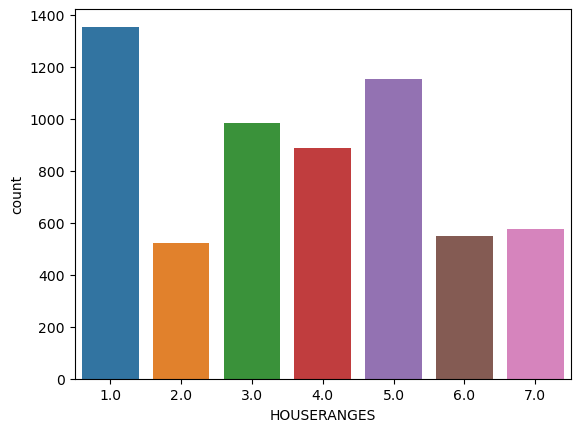

In [163]:
import seaborn as sns
sns.countplot(x = 'HOUSERANGES', data = data)

# the distribution remains similar to the original one before imputation

In [164]:
data['HOUSERANGES'].value_counts()

1.0    1354
5.0    1152
3.0     984
4.0     887
7.0     576
6.0     549
2.0     523
Name: HOUSERANGES, dtype: int64

__VALUERANGES__

'If you were to sell your home today, what do you think it would be worth?'

Impute using KNN:

HOUSERANGES: ordinal
<br>
HOUSESAT: ordinal
<br>
PPINCIMP: ordinal

distance: euclidean

In [165]:
data[data['VALUERANGES'].isna()].shape[0]

168

In [166]:
valid_data = data[data['VALUERANGES'] != -2]

In [167]:
imputer = KNNImputerMode(n_neighbors = 5)

cols = ['HOUSERANGES', 'HOUSESAT', 'PPINCIMP', 'MORTGAGE', 'VALUERANGES']

new_data = imputer.fit_transform(valid_data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = valid_data.index)

In [168]:
data.loc[data['VALUERANGES'].isna(), 'VALUERANGES'] = new_data.loc[data['VALUERANGES'].isna(), 'VALUERANGES'].copy()

In [169]:
data['VALUERANGES'].isna().sum()

0

<AxesSubplot:xlabel='VALUERANGES', ylabel='count'>

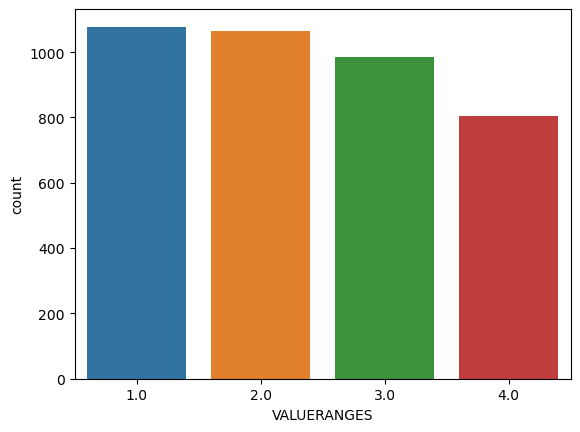

In [170]:
sns.countplot(x = 'VALUERANGES', data = data[data['VALUERANGES'] != -2])

Again, the distribution remains really similar to the original one

__MORTGAGE__

'What do you owe on your home today?'

In [171]:
data[data['MORTGAGE'].isna()].shape[0]

516

In [172]:
valid_data = data[data['MORTGAGE'] != -2]

In [173]:
imputer = KNNImputerMode(n_neighbors = 5)

cols = ['HOUSERANGES', 'PPHHSIZE', 'PPINCIMP', 'VALUERANGES', 'MORTGAGE']

new_data = imputer.fit_transform(valid_data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = valid_data.index)

In [174]:
data.loc[data['MORTGAGE'].isna(), 'MORTGAGE'] = new_data.loc[data['MORTGAGE'].isna(), 'MORTGAGE'].copy()

<AxesSubplot:xlabel='MORTGAGE', ylabel='count'>

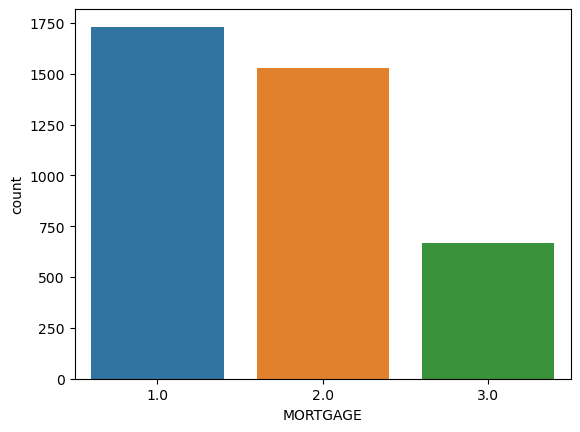

In [175]:
sns.countplot(x = 'MORTGAGE', data = data[data['MORTGAGE'] != -2])

__SAVINGSRANGES__

'How much money do you have in savings today?'

KNN imputation using:

SAVEHABIT: ordinal
<br>
PRODHAVE_1: binary
<br>
MATHARDSHIP_1: ordinal
<br>
COLLECT: ordinal
<br>
PPINCIMP: ordinal

distance: euclidean + hamming

In [176]:
data[data['SAVINGSRANGES'].isna()].shape[0]

939

In [177]:
def distance(X, Y, missing_values = np.nan):
    X[np.isnan(X)] = 0
    Y[np.isnan(Y)] = 0

    eucl_dist = euclidean(X[[0, 2, 3, 4]], Y[[0, 2, 3, 4]])

    return eucl_dist + (X[1] != Y[1])

In [178]:
imputer = KNNImputerMode(n_neighbors = 5, metric = distance)

cols = ['SAVEHABIT', 'PRODHAVE_1', 'MATHARDSHIP_1', 'COLLECT', 'PPINCIMP', 'SAVINGSRANGES']

new_data = imputer.fit_transform(data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = data.index)

In [179]:
data.loc[data['SAVINGSRANGES'].isna(), 'SAVINGSRANGES'] = new_data.loc[data['SAVINGSRANGES'].isna(), 'SAVINGSRANGES'].copy()

__BORROW_1__

'My friends or family would lend me the money and expect me to repay them'

In [180]:
data[data['BORROW_1'].isna()].shape[0]

112

In [181]:
data.loc[data['BORROW_1'].isna(), 'BORROW_1'] = data['BORROW_1'].mode()[0]

__BORROW_2__

'My friends or family would give me the money with no expectation of'

In [182]:
data[data['BORROW_2'].isna()].shape[0]

204

In [183]:
data.loc[data['BORROW_2'].isna(), 'BORROW_2'] = data['BORROW_2'].mode()[0]

__HSLOC__

'Where did you live at age 17?'

In [184]:
data[data['HSLOC'].isna()].shape[0]

514

In [185]:
data.loc[data['HSLOC'].isna(), 'HSLOC'] = data['HSLOC'].mode()[0]

__CONNECT__

Psychological connectedness

KNN imputation using:

PPINCIMP: ordinal
<br>
DISSTRESS: ordinal
<br>
agecat: ordinal
<br>
CHANGEABLE: ordinal

distance: euclidean

In [186]:
data[data['CONNECT'].isna()].shape[0]

291

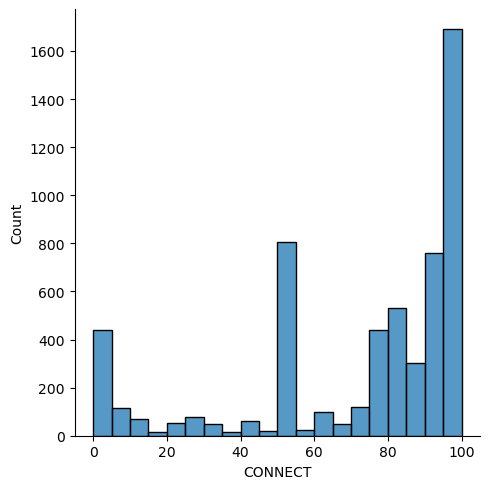

In [187]:
sns.displot(x = 'CONNECT', data = data)

In [202]:
imputer = KNNImputerMedian(n_neighbors = 5)

cols = ['PPINCIMP', 'DISTRESS', 'agecat', 'CHANGEABLE', 'CONNECT']

new_data = imputer.fit_transform(data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = data.index)

new_data

/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


,PPINCIMP,DISTRESS,agecat,CHANGEABLE,CONNECT
PUF_ID,,,,,
10350,7.0,4.0,8.0,4.0,80.0
7740,6.0,3.0,3.0,2.0,95.0
13699,6.0,2.0,3.0,6.0,50.0
7375,7.0,3.0,2.0,4.0,0.0
10910,7.0,4.0,2.0,1.0,80.0
...,...,...,...,...,...
11620,3.0,5.0,2.0,7.0,0.0
11220,9.0,2.0,7.0,2.0,50.0
8709,9.0,4.0,2.0,4.0,50.0


In [203]:
data.loc[data['CONNECT'].isna(), 'CONNECT'] = new_data.loc[data['CONNECT'].isna(), 'CONNECT'].copy()

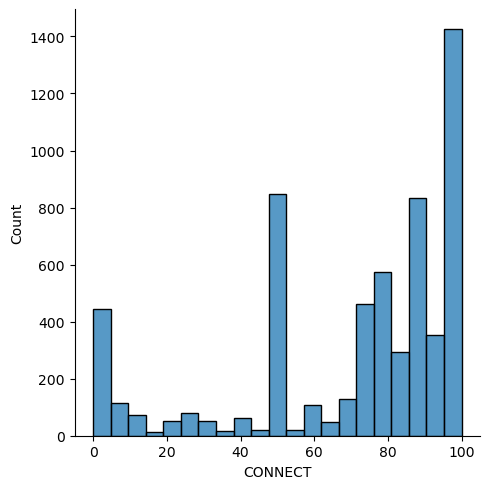

In [204]:
sns.displot(x = 'CONNECT', data = data)

__LIFEEXPECT__


'How likely do you believe it is that you will live beyond age 75?'

KNN Imputation usign variables:

HEALTH: ordinal
<br>
SWB_2: ordinal
<br>
DISTRESS: ordinal

distance: euclidean


In [205]:
data[data['LIFEEXPECT'].isna()].shape[0]

212

In [214]:
imputer = KNNImputerMedian(n_neighbors = 5)

cols = ['HEALTH', 'SWB_2', 'DISTRESS', 'LIFEEXPECT']

new_data = imputer.fit_transform(data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = data.index)

/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [215]:
data.loc[data['LIFEEXPECT'].isna(), 'LIFEEXPECT'] = new_data.loc[data['LIFEEXPECT'].isna(), 'LIFEEXPECT'].copy()

__KIDS_NoChildren__

'I have no children that I support financially'

In [216]:
data[data['KIDS_NoChildren'].isna()].shape[0]

473

All KIDS variables will be excluded due to probable missinterpretation and redudancy with accurate panel data

In [217]:
data.drop(list(filter(lambda x: 'KIDS' in x, data.columns.values)), axis =1, inplace = True)

In [218]:
data.shape

(6025, 166)

# Feature engineering

__Subjective Well Being__

<AxesSubplot:>

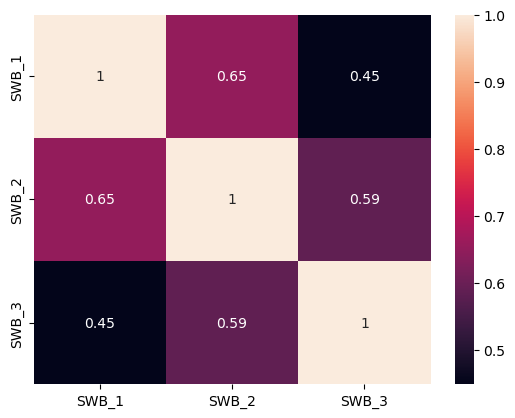

In [226]:
feats = list(filter(lambda x: 'SWB' in x, data.columns.values))
# spearman correlation
sns.heatmap(data[feats].corr(method = 'spearman'), annot = True)

__Acountability__

<AxesSubplot:>

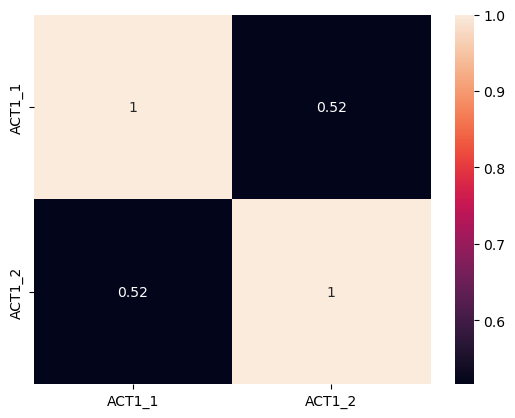

In [227]:
feats = list(filter(lambda x: 'ACT' in x, data.columns.values))
# spearman correlation
sns.heatmap(data[feats].corr(method = 'spearman'), annot = True)

__Financial Planning__

<AxesSubplot:>

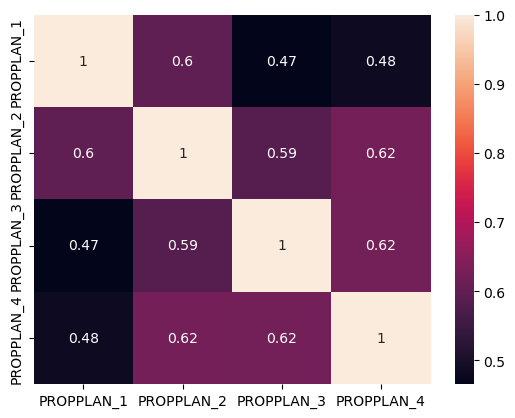

In [228]:
feats = list(filter(lambda x: 'PROPPLAN' in x, data.columns.values))
# spearman correlation
sns.heatmap(data[feats].corr(method = 'spearman'), annot = True)

__Financial competence__

<AxesSubplot:>

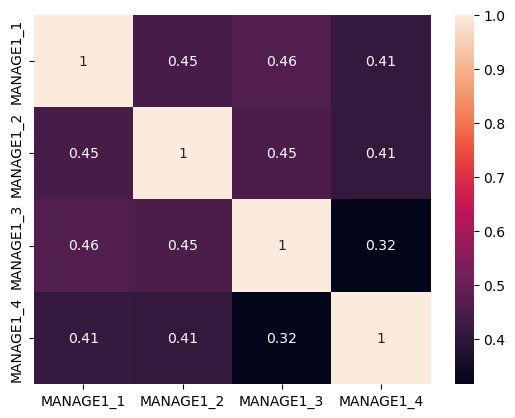

In [229]:
feats = list(filter(lambda x: 'MANAGE1' in x, data.columns.values))
# spearman correlation
sns.heatmap(data[feats].corr(method = 'spearman'), annot = True)

<AxesSubplot:>

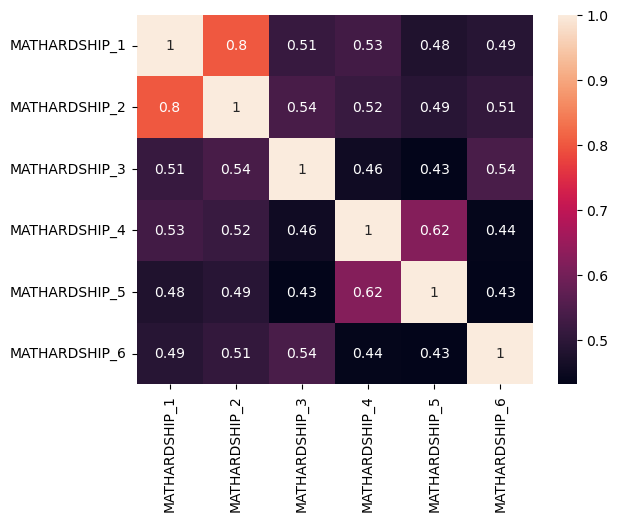

In [242]:
feats = list(filter(lambda x: 'MATHARDSHIP' in x, data.columns.values))
# spearman correlation
sns.heatmap(data[feats].corr(method = 'spearman'), annot = True)

<AxesSubplot:>

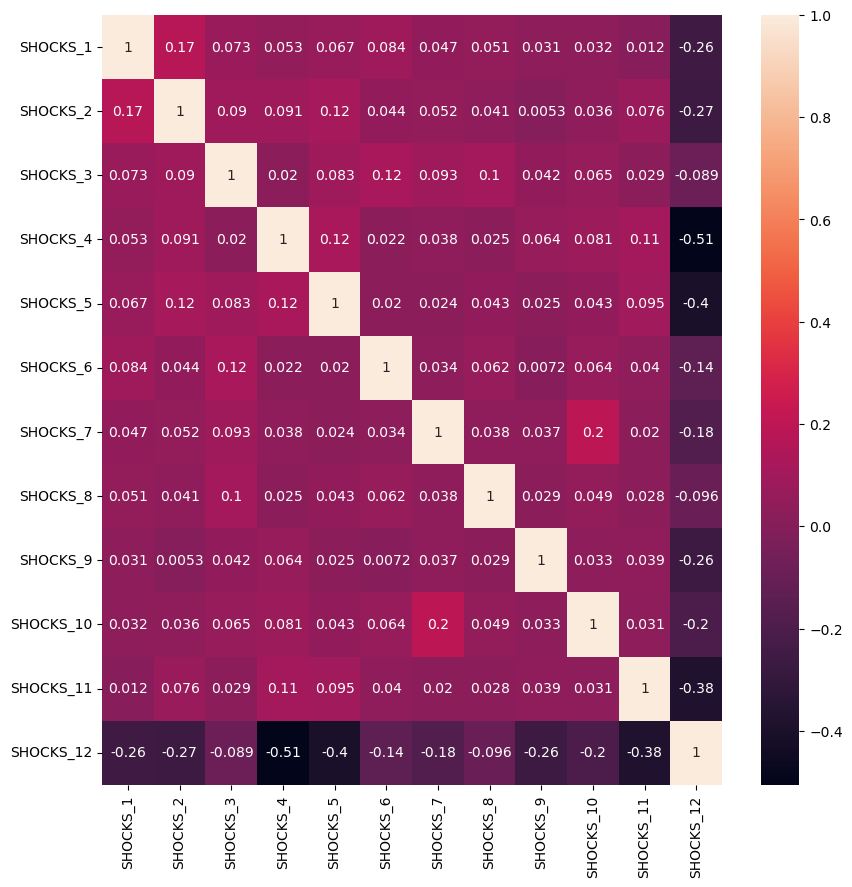

In [246]:
plt.figure(figsize = (10, 10))
feats = list(filter(lambda x: 'SHOCKS' in x, data.columns.values))
# spearman correlation
sns.heatmap(data[feats].corr(method = 'spearman'), annot = True)

<AxesSubplot:>

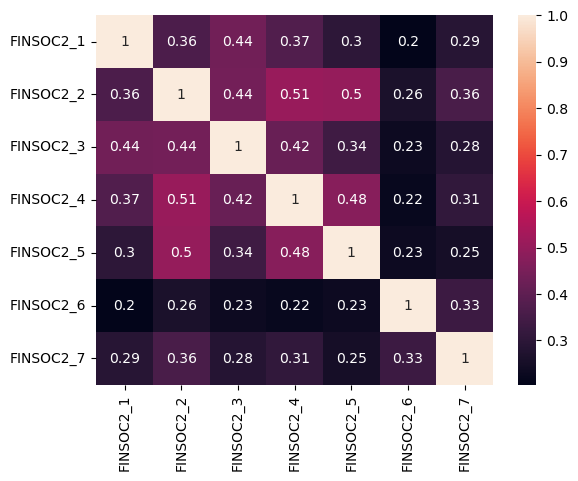

In [247]:
feats = list(filter(lambda x: 'FINSOC' in x, data.columns.values))
# spearman correlation
sns.heatmap(data[feats].corr(method = 'spearman'), annot = True)

<AxesSubplot:>

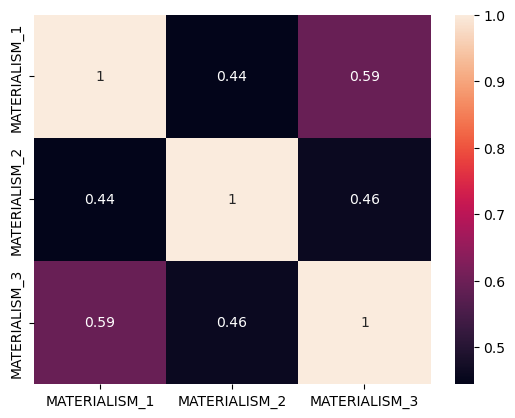

In [253]:
feats = list(filter(lambda x: 'MATERIALISM' in x, data.columns.values))
# spearman correlation
sns.heatmap(data[feats].corr(method = 'spearman'), annot = True)

<AxesSubplot:>

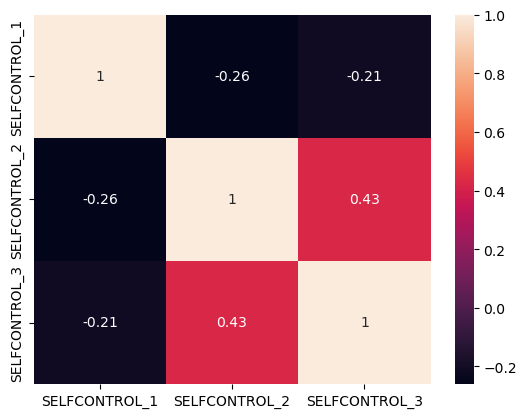

In [254]:
feats = list(filter(lambda x: 'SELFCONTROL' in x, data.columns.values))
# spearman correlation
sns.heatmap(data[feats].corr(method = 'spearman'), annot = True)

<AxesSubplot:>

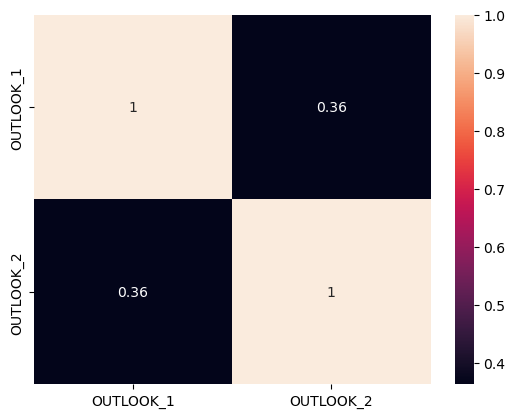

In [255]:
feats = list(filter(lambda x: 'OUTLOOK' in x, data.columns.values))
# spearman correlation
sns.heatmap(data[feats].corr(method = 'spearman'), annot = True)

<AxesSubplot:>

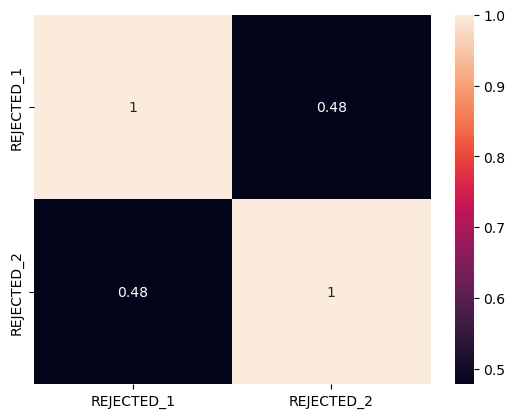

In [259]:
feats = list(filter(lambda x: 'REJECTED' in x, data.columns.values))
# spearman correlation
sns.heatmap(data[feats].corr(method = 'spearman'), annot = True)

# One hot encoding

Categorical variables: sample, AUTOMATED_1, AUTOMATED_2, HOUSING, LIVINGARRANGEMENT, COVERCOSTS, HSLOC, DISCOUNT (binary), Military_Status, generation, PPETHM, PPGENDER (binary), PPMARIT, PPREG4, PPREG9

In [302]:
data.shape

(6025, 166)

In [296]:
cat_feats = ['sample', 'AUTOMATED_1', 'AUTOMATED_2', 'HOUSING', 'LIVINGARRANGEMENT',
'COVERCOSTS', 'HSLOC', 'DISCOUNT', 'Military_Status', 'generation', 'PPETHM', 'PPGENDER', 'PPMARIT', 'PPREG4', 'PPREG9']

In [304]:
# one hot encoding
data = pd.get_dummies(data, columns = cat_feats, drop_first = True)

(6025, 194)

In [310]:
data.drop('EMPLOY', axis = 1, inplace = True) # drop employ because it is already one hot enconded
data.drop('EMPLOY1_9', axis = 1, inplace = True) # drop because of perfect collinearity problem

In [312]:
data.shape

(6025, 192)

# Feature selection

In [327]:
# get all columns with more values than 0 and 1
num_feats = list(filter(lambda x: data[x].nunique() > 2, data.columns.values))

cat_feats = list(filter(lambda x: data[x].nunique() == 2, data.columns.values))

<AxesSubplot:>

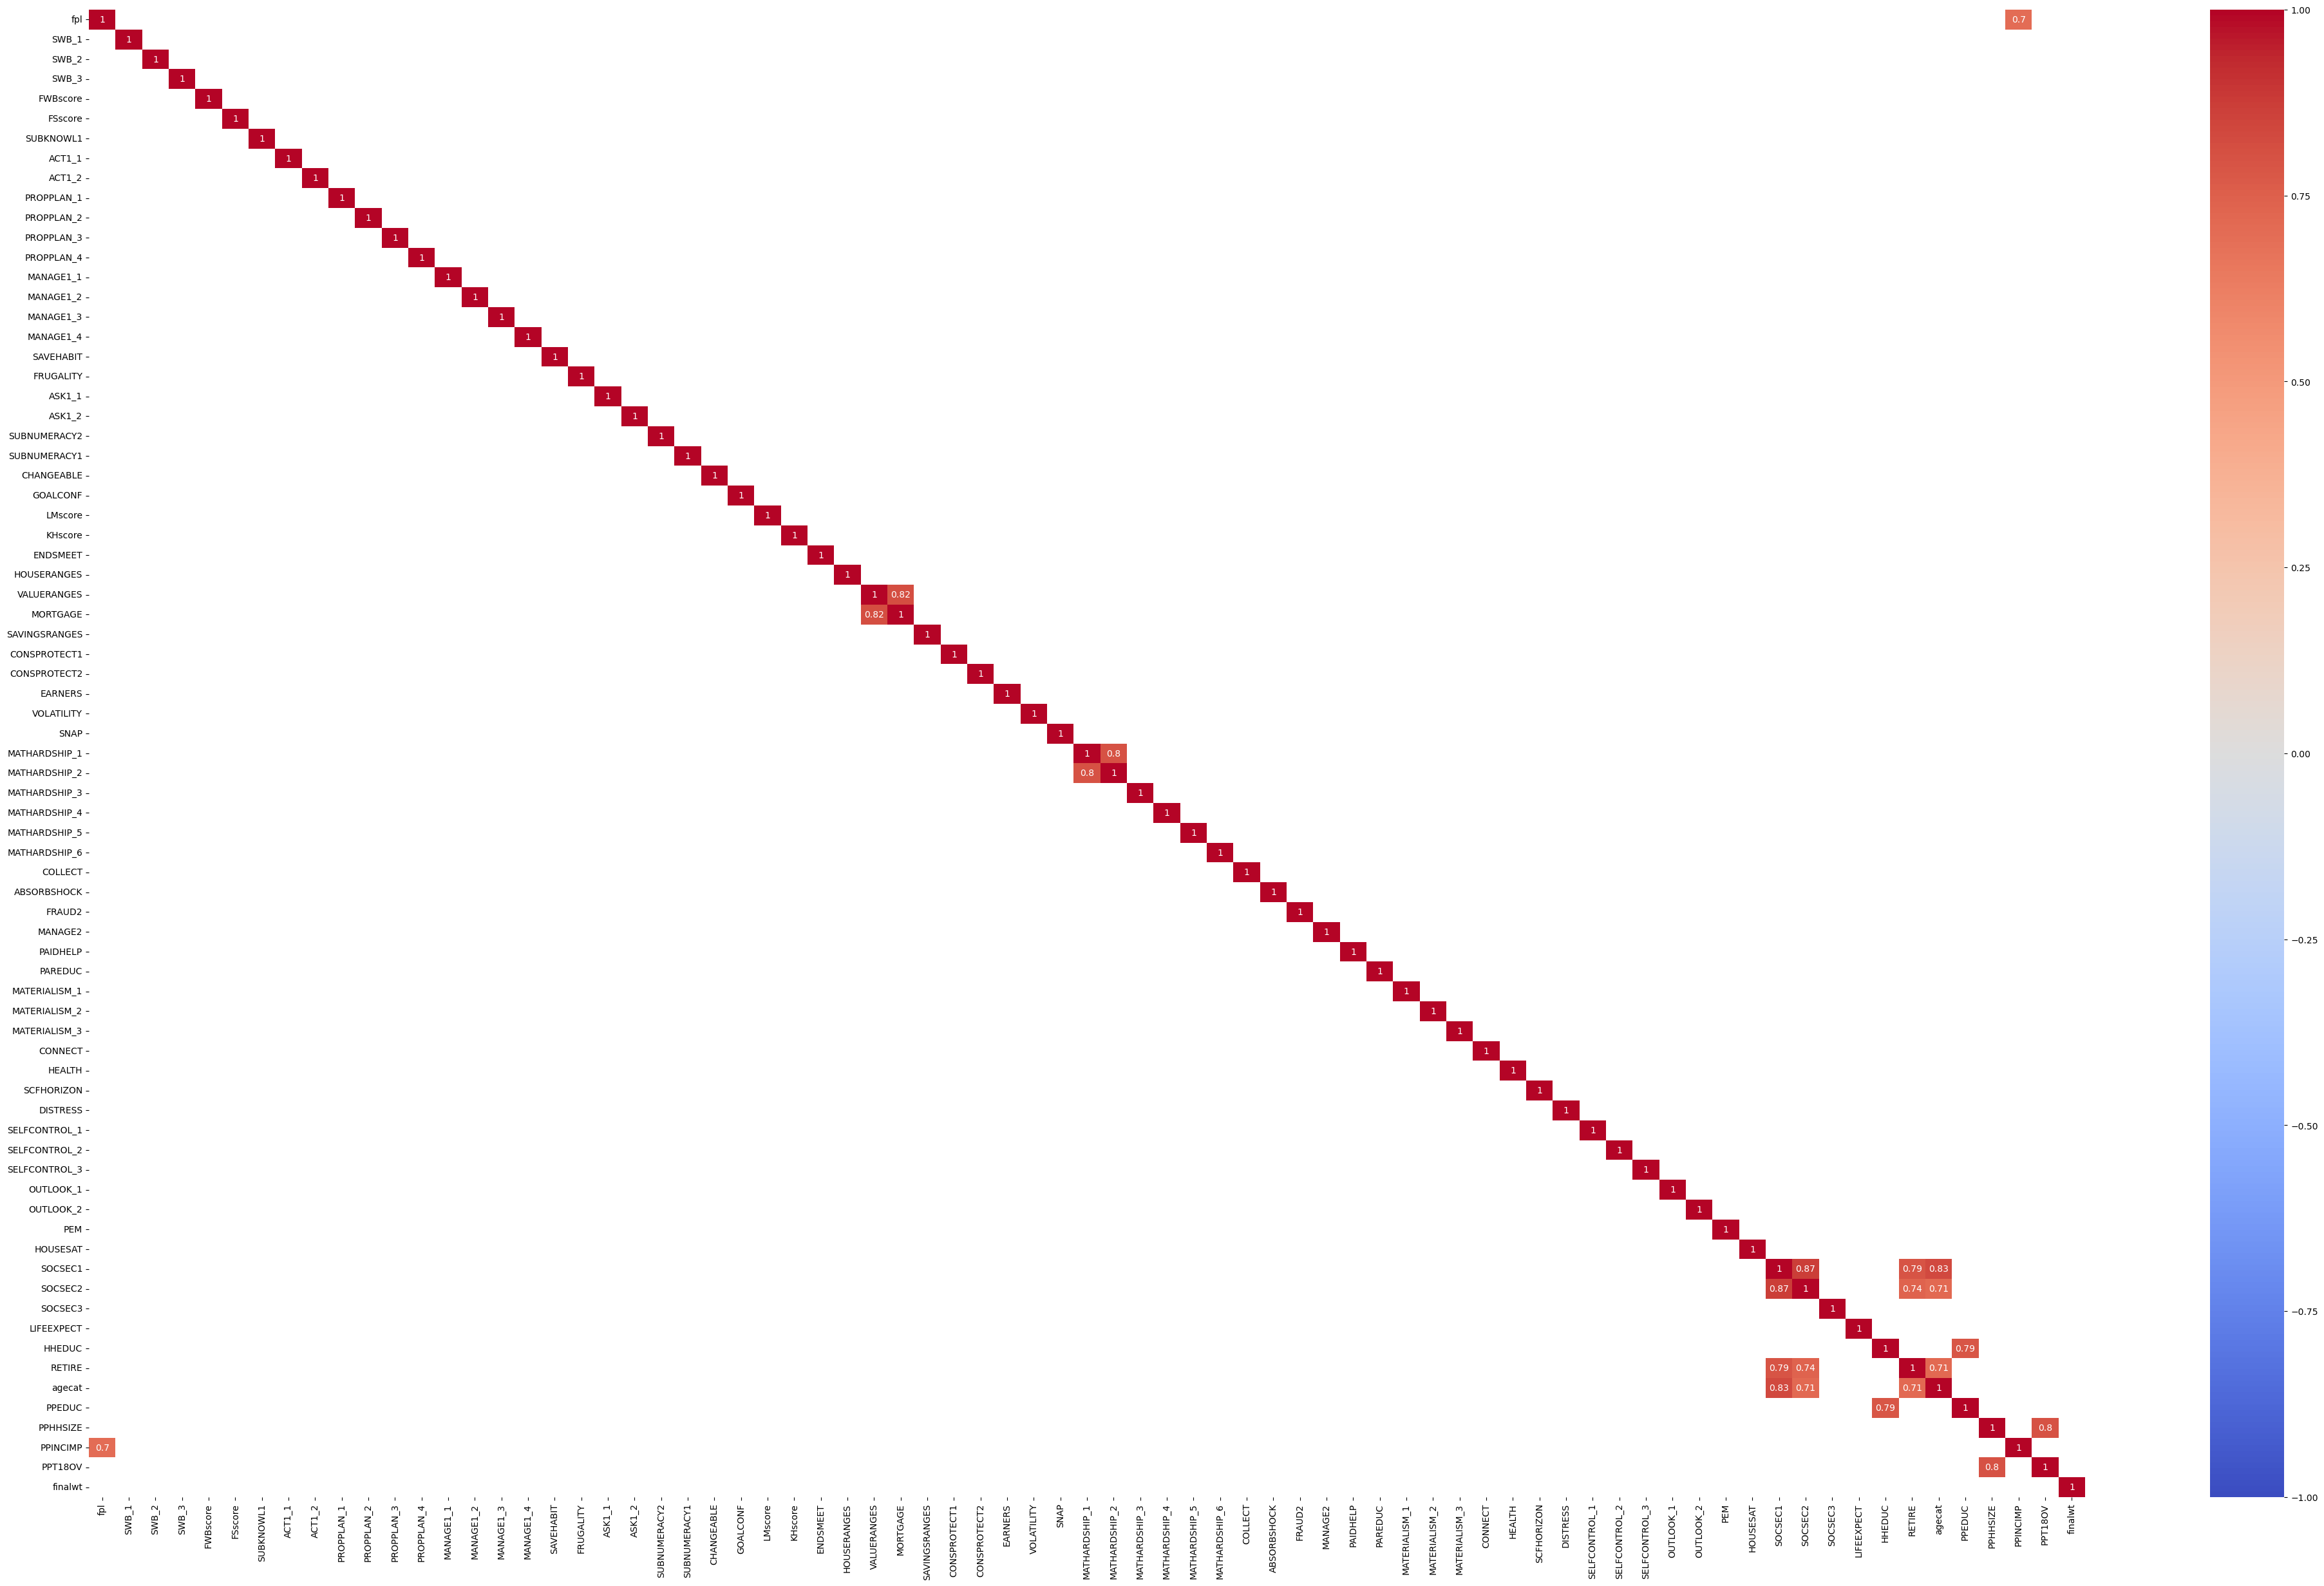

In [342]:
# sns.heatmap(data[num_feats].corr(method = 'spearman'), annot = True)

# sns heatmap with annot and only on one side of the diagonal and only on correlations above 0.7
plt.figure(figsize = (50, 30))
sns.heatmap(data[num_feats].corr(method = 'spearman')[data[num_feats].corr(method = 'spearman') > 0.7].dropna(how = 'all').dropna(how = 'all', axis = 1), annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)


# TODO: There are high correlations because of the -2 answers

In [351]:
# get pairs of features with correelation above 0.7
corr = data[num_feats].corr(method = 'spearman')
corr[corr > 0.7].notna().sum()[corr[corr > 0.7].notna().sum() > 1] # columns that are highly correlated with others

fpl              2
VALUERANGES      2
MORTGAGE         2
MATHARDSHIP_1    2
MATHARDSHIP_2    2
SOCSEC1          4
SOCSEC2          4
HHEDUC           2
RETIRE           4
agecat           4
PPEDUC           2
PPHHSIZE         2
PPINCIMP         2
PPT18OV          2
dtype: int64

In [353]:
# correlation between VALUERANGES and other features
data[num_feats].corr(method = 'spearman')['VALUERANGES'].sort_values(ascending = False) # VALUERANGES and MORTGAGE

VALUERANGES      1.000000
MORTGAGE         0.817726
PPINCIMP         0.500516
SAVINGSRANGES    0.483665
FWBscore         0.416952
                   ...   
MATHARDSHIP_3   -0.268142
SNAP            -0.293869
MATHARDSHIP_2   -0.308333
MATHARDSHIP_1   -0.320055
ENDSMEET        -0.328576
Name: VALUERANGES, Length: 75, dtype: float64